We will now use everything we have learned thus far to study an cloud of atoms. This essentially means that we have to take into account that the atoms will vary in velocity and will "see" the light to be at different frequencies, thus not being at resonance. Due to the doppler effect, we have the following hamiltonian in RWA and rotating frame
$$
H = \hbar
\begin{bmatrix}
    0 & \Omega\\
    \Omega^* & (1+\frac{\Delta v}{c})\cdot\alpha (t-t') + \omega_0\frac{\Delta v}{c} - \delta (1+\frac{\Delta v}{c})
\end{bmatrix}
$$
where $\delta$ is the global laser detuning. Sign of detuning prooooobably doesn't matter. It's just a matter of convention. If blue-detuned, what sign is it?

In [1]:
import numpy as np
import qutip as qt
import scipy as sp
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import csvkit as csv
import random

Use that the velocities are distributed as a Maxwell distribution, namely
$$
f(v)dv = \Big(\frac{m}{2\pi kT}\Big)^{1/2} \cdot \exp\{-\frac{m v^2}{2kT}\}dv
$$
centred at $\mu = 0$ with standard deviation $\sigma = \sqrt{\frac{kT}{m}}$

In [2]:
#Define N=1000 atoms with varying detunings based on Maxwell distribution
random.seed(0)
N_atoms = int(1e5)

T = 300 #K temperature of cloud
"""
m = 2*511 #keV/c^2 mass of positronium
k = 8.617e-8 #[keV  K^-1] boltzmann constant
"""
m = 2*9.1e-31 #kg
k = 1.38e-23 # [J K^-1]
sigma = np.sqrt(k*T/m) #standard deviation of gaussian

# for some dumb reason the temperature has little to no influence on the velocity profile.
# I am therefore temporarily multiplying by a constant such that the speed is of the same order of magnitude as found in Christian Zimmer's dissertation

amplitude = np.sqrt(m/(2*np.pi*k*T))
rms_speed = np.sqrt((3*k*T)/m)
print(rms_speed)
velocities = np.random.normal(loc=0,scale=sigma,size=N_atoms) *1e-10#cm/ps
# perhaps velocities need to be scaled relative to time bin, too?

82608.56991968704


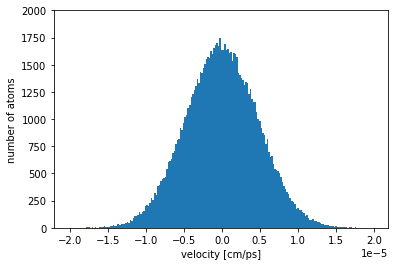

In [3]:
N_bins = 200
hist = plt.hist(velocities,bins=N_bins)

plt.ylim(0,2000)
plt.xlabel("velocity [cm/ps]")
plt.ylabel("number of atoms")
plt.show()

In [4]:
hbar = 1#6.582e-16 * 1e12 #eV ps
hbar_eV = 6.58e-4 # hbar/eV = 6.58e-4 ps, for conversion purposes
c = 3e8 * 1e-10 # cm/ps
D = 0.0208e-7 # e*cm, Debye

pulse_duration =  10 #ps 
wavelength = 243e-7 # cm
energy_splitting =  5#hbar*c/wavelength # eV

omega0 = energy_splitting / hbar / hbar_eV # 2pi THz 
period = wavelength/c
detuning =  2*np.pi*(0.152) #
# to properly plot the carrier signal, the binwidth needs to be smaller than 1 period of oscillation.
binwidth = 2*np.pi/omega0*100 # 1000 periods of oscillation

endTime = 2*pulse_duration
N = int(endTime/binwidth)
tlist = np.linspace(0,endTime,N)
tshift = endTime*0.5
tlist_shift = np.full(N,tshift)

print("omega0=2pi({:.3f}) THz".format(omega0/(2*np.pi)))
print("detuning=2pi({}) THz".format(detuning/(2*np.pi)))

omega0=2pi(1209.384) THz
detuning=2pi(0.152) THz


In [5]:
rank = 2
kets = [qt.basis(2,i) for i in range(rank)]
projs = [qt.ket2dm(ket) for ket in kets]
c_ops =[]
psi0 = qt.fock(2,0)

#perhaps rescale chirp with timescale? Not sure this is necessary yet
chirp = 0#2*np.pi*0.5 # THz/ps   
rabi0 = 0.32 # THz

print("energy_splitting={:.2f}ev".format(energy_splitting))
print("chirp={:.2f} radians THz/ps, rabi0={:.2f} radians THz".format(chirp,rabi0))
print("period={:.2f} fs".format(period*1e3))
# currently unused
dipole_moment = 1*D # [Debye]

energy_splitting=5.00ev
chirp=0.00 radians THz/ps, rabi0=0.32 radians THz
period=0.81 fs


In [6]:
populations = hist[0]
velocity_bins = np.asarray([ hist[1][i] for i in range(N_bins)] )

In [7]:
def evolve(omega0,detuning,chirp,rabi0,pulse_duration):
    endTime = 2*pulse_duration
    N = int(endTime/binwidth)
    tlist = np.linspace(0,endTime,N)
    tshift = endTime*0.5
    tlist_shift = np.full(N,tshift)
    
    rabi = lambda t, args: rabi0 * np.exp(-4*np.log(2)*(t-tshift)**2/pulse_duration**2)
    final_pops = []
    for vel in velocity_bins:
        H0 = hbar*qt.Qobj([[0,0],[0,omega0*vel/c -detuning*(1+vel/c)]])
        H_chirp = hbar*qt.Qobj([[0,0],[0,chirp*(1+vel/c)]])
        H_transition = 0.5*hbar*qt.sigmax()
        H = [H0,[H_chirp,tlist-tlist_shift],[H_transition,rabi]]

        result = qt.mesolve(H, psi0,tlist,c_ops,e_ops=projs)
        final_pops.append(result.expect[1][-1])
    
    return final_pops

In [8]:
final_pops = evolve(omega0,detuning,chirp,rabi0)

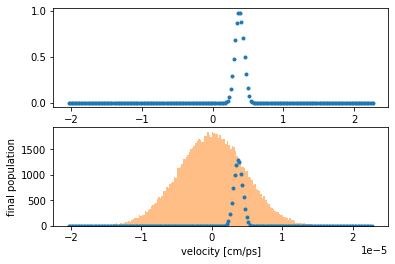

In [9]:
# simulate for many chirps and put them on top of each other

fig,axs = plt.subplots(2)
axs[0].plot(velocity_bins,final_pops,'.')
axs[1].plot(velocity_bins,final_pops*populations,'.')

#axs[0].set_xlim(0.25e-5,0.5e-5)
#axs[0].axvline(velocity_bins[580],color='r')
axs[1].hist(velocities,N_bins,alpha=0.5)
axs[1].set_xlabel(r"velocity [cm/ps]")
axs[1].set_ylabel("final population")
#axs[0].set_title(r"Selective excitation due to doppler effect, $\alpha ={}, rabi0={}$".format(chirp,rabi0))
#plt.savefig("./figures/doppler/detuning_vs_finalpop",bbox_inches="tight")
plt.show()

## Plots illustrating how different detuning and chirps affect the selection ranges

In [9]:
pulse_durations =  [1,2,5,10,20] #ps 
energy_splitting =  5 # eV

omega0 = energy_splitting / hbar / hbar_eV # 2pi THz 
period = wavelength/c
detunings =  2*np.pi*np.asarray([-0.2,0,0.152,0.25])

chirps = 2*np.pi*np.asarray([0,0.05,0.1]) #2*np.pi*0.5 # THz/ps   
rabi0 = 1.5 # THz

binwidth = 2*np.pi/omega0*100 # 1000 periods of oscillation
final_pops = np.zeros((5,N_bins))

In [11]:
for i in range(detunings.size):
    final_pops[i] = evolve(omega0,detunings[i],chirps[0],rabi0,pulse_durations[3])    

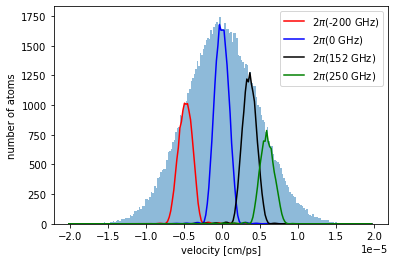

In [13]:
colors = ['red','blue','black','green']
plt.hist(velocities,N_bins,alpha=0.5)
plt.xlabel("velocity [cm/ps]")
plt.ylabel("number of atoms")
for i in range(detunings.size):
    plt.plot(velocity_bins,final_pops[i]*populations,color=colors[i],label=r"$2\pi$({:.0f} GHz)".format(detunings[i]/(2*np.pi)*1e3))
plt.legend()
plt.savefig("./figures/report2/detunings_doppler_selection")

In [77]:
for i in range(chirps.size):
    final_pops[i] = evolve(omega0,detunings[2],chirps[i],rabi0)

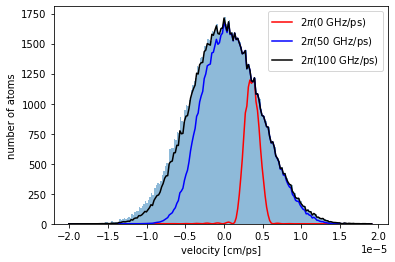

In [80]:
colors = ['red','blue','black','green']
plt.hist(velocities,N_bins,alpha=0.5)
plt.xlabel("velocity [cm/ps]")
plt.ylabel("number of atoms")
for i in range(chirps.size):
    plt.plot(velocity_bins,final_pops[i]*populations,color=colors[i],label=r"$2\pi$({:.0f} GHz/ps)".format(chirps[i]/(2*np.pi)*1e3))
plt.legend()
plt.savefig("./figures/report2/chirps_doppler_selection")

In [11]:
for i in range(len(pulse_durations)):
    final_pops[i] = evolve(omega0,detunings[1],chirps[0],rabi0,pulse_durations[i])

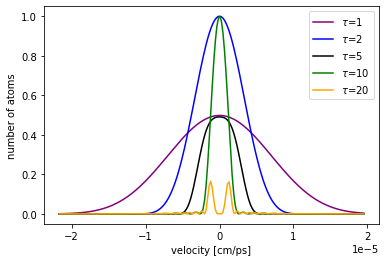

In [16]:
colors = ['purple','blue','black','green',"orange"]
plt.xlabel("velocity [cm/ps]")
plt.ylabel("number of atoms")
for i in range(len(pulse_durations)):
    plt.plot(velocity_bins,final_pops[i],color=colors[i],label=r"$\tau$={:.0f}".format(pulse_durations[i]))
plt.legend()
#plt.savefig("./figures/report2/chirps_doppler_selection")

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

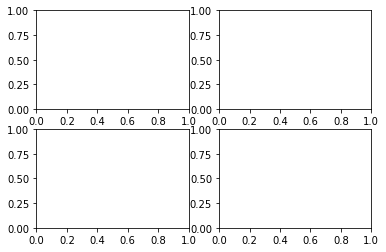

In [74]:
gaussian = lambda v,a,b: a*np.exp(-b*v**2)
fig,axs = plt.subplots(2,2)
for i in range(len(pulse_durations)-1):
    popt,pcov = sp.optimize.curve_fit(gaussian,velocity_bins,final_pops[i])
    # perhaps normalize by dividing by popt[0]?
    axs[i].set_title(r"$\tau={:.0f}$ps, $\sigma_v$={:.0e}cm/ps, $\Delta \sigma_v$ = {:.2e}".format(pulse_durations[i],1/popt[1], popt[1]/pcov[1][1]))
    axs[i].semilogy(velocity_bins, gaussian(velocity_bins,popt[0],popt[1]))
    axs[i].semilogy(velocity_bins, final_pops[i],'.',alpha=0.2)
    axs[i].set_ylim(0.1,1)
plt.savefig("./figures/report2/fits")
plt.show()